In [130]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [932]:
%matplotlib inline

In [1055]:
import networkx as nx
import numpy as np
import os
import pandas as pd
from scipy.stats import describe
from collections import defaultdict as ddict
import matplotlib.pyplot as plt
import random 
import pickle

from torch_geometric.utils.convert import from_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.data import batch, Data, InMemoryDataset, DataLoader
import torch
import torch_geometric 
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import MSELoss, L1Loss

In [2]:
A = np.load('eec/1111.npz')

df = pd.read_csv('eec/df_raven.csv')
intelligence = dict(zip(df.twinid, df.pcrvtot))

In [229]:
A = np.loadtxt('ZG_wpli/231_ZG_6-sec_wpli_sensors_13-20.csv', delimiter=',')

In [1024]:
class Dataset:
    def __init__(self, folder, target_file, human2data=None):
        self.folder = folder
        self.target_file = target_file
        self.human2data = human2data

    def get_graphs_path(self, ext='csv'):
        return [self.folder + '/' + fn for fn in os.listdir(self.folder) if fn.endswith(ext)]

    def get_labels(self):
        target = pd.read_csv(self.target_file)
        target = target[~target.pcrvtot.isna()]
        return dict(zip(target.twinid, target.pcrvtot))

    def get_matrices(self, sep=','):
        human2iq = self.get_labels()
        human2matrices = ddict(list)
        for p in os.listdir(self.folder):
            human = int(p.split('_')[0])
            if human in human2iq:
                human2matrices[human].append(np.loadtxt(self.folder + '/' + p, delimiter=sep))
        return human2matrices

    def matrix_to_graph_threshold(self, A, percentiles=range(10, 91, 10)):
        flattened = A.flatten()
        flattened_pos = flattened[flattened > 0]
        graphs = []
        for p in percentiles:
            B = A.copy()
            t = np.percentile(flattened_pos, p)
            B[B < t] = 0
            graphs.append(nx.from_numpy_matrix(B))
        return graphs

    def matrix_to_graph_spanner(self, A, stretch, rep=10, weight='weight', seed=None):
        G = nx.from_numpy_matrix(A)
        return [nx.sparsifiers.spanner(G, stretch, weight=weight, seed=seed) for _ in range(rep)]

    def get_graph_data(self, method='threshold', percentiles=range(10, 91, 10), stretch=5, rep=10, weight='weight',
                       seed=None):
        human2iq = self.get_labels()
        human2matrices = self.get_matrices()

        human2data = ddict(list)
        for human in human2matrices:
            label = human2iq[human]
            for matrix in human2matrices[human]:
                if method == 'threshold':
                    graphs = self.matrix_to_graph_threshold(matrix, percentiles)
                elif method == 'spanner':
                    graphs = self.matrix_to_graph_spanner(matrix, stretch=stretch, rep=10, weight='weight', seed=None)
                human2data[human].extend(list(zip(graphs, [label] * len(graphs))))
        self.human2data = human2data
        
class GIN(torch.nn.Module):
    def __init__(self, input_dim, dim=32):
        super(GIN, self).__init__()

        nn1 = Sequential(Linear(input_dim, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x
    
    
class Pipeline():
    def __init__(self, model, human2data):
        self.model = model
        self.human2data = human2data
        
        self.mse = MSELoss()
        self.mae = L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        
    def from_networkx(self, G, human, y=None, edge_name = None):
        G = nx.convert_node_labels_to_integers(G)
        G = G.to_directed() if not nx.is_directed(G) else G
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = {}

        for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
            for key, value in feat_dict.items():
                data[key] = [value] if i == 0 else data[key] + [value]

        for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
            for key, value in feat_dict.items():
                if edge_name is not None:
                    key = edge_name
                data[key] = [value] if i == 0 else data[key] + [value]
                
        degrees = nx.degree(G, weight='weight')
        data['x'] = torch.tensor([degrees[node] for node in range(len(G))])


        for key, item in data.items():
            try:
                data[key] = torch.tensor(item)
            except ValueError:
                pass

        data['edge_index'] = edge_index.view(2, -1)
        
        if y is not None:
            data['y'] = y
        data['human'] = torch.tensor([human])
        
        data = torch_geometric.data.Data.from_dict(data)
        data.num_nodes = G.number_of_nodes()

        return data
    
    def create_loader(self, humans, batch_size=128, shuffle=True):
        data_list = []
        for human in humans:
            graphs = self.human2data[human]
            data_list.extend([self.from_networkx(G, human, l, edge_name='edge_attr') for (G, l) in graphs])
        if batch_size == -1:
            batch_size = sum(list(map(len, data_list)))
        return DataLoader(data_list, batch_size=batch_size, shuffle=shuffle) 
        
        
    def kfold_split(self, nsplits, batch_size=128):
        human2data = self.human2data
        humans = np.array(list(human2data.keys()))
        kfold = KFold(nsplits, shuffle=True)
        for train_ix, test_ix in kfold.split(humans):
            train_humans = humans[train_ix]
            test_humans = humans[test_ix]
            train_loader = self.create_loader(train_humans, batch_size=128, shuffle=True)
            test_loader = self.create_loader(test_humans, batch_size=-1, shuffle=False)
            
            yield train_loader, test_loader
        
    def compute_human_predictions_and_scores(self, humans, predictions, human_labels):
        "This computes predictions per human by taking mean of individual human's predictions."
        "https://stackoverflow.com/a/56155805/2069858"

        human2score = dict(zip(humans.numpy(), human_labels.numpy()))

        human2ix = dict()
        ix2human = dict()
        avg_human_scores = []
        for ix, human in enumerate(humans.unique()):
            human2ix[human.item()] = ix
            ix2human[ix] = human.item()
            avg_human_scores.append(human2score[ix2human[ix]])


        avg_human_scores = torch.tensor(avg_human_scores).unsqueeze(-1)


        # this part computes avg predictions by human
        indexes = torch.tensor([human2ix[human.item()] for human in humans])
        n_predictions = predictions.size()[0]
        M = torch.zeros(indexes.max()+1, n_predictions)
        M[indexes, torch.arange(n_predictions)] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        if len(predictions.size()) == 1:
            predictions = predictions.unsqueeze(-1)
        avg_human_predictions = torch.mm(M, predictions)
        return avg_human_predictions, avg_human_scores
            
    def trainx(self, data_loader):
        self.model.train()
        
        loss_epoch = 0
        for data in data_loader:
            self.optimizer.zero_grad()
            output = self.model(data.x, data.edge_index, data.batch)
            predictions, scores = self.compute_human_predictions_and_scores(data.human, output, data.y)

            loss = self.mse(predictions, scores)
            loss_epoch += loss.item()
            loss.backward()
            self.optimizer.step()
        return loss_epoch
            
    def testx(self, data_loader):
        self.model.eval()

        for data in data_loader:
            output = self.model(data.x, data.edge_index, data.batch)
            predictions, scores = self.compute_human_predictions_and_scores(data.human, output, data.y)
            mse_loss = self.mse(predictions, scores).item()
            mae_loss = self.mae(predictions, scores).item()
        return mse_loss, mae_loss
    
    def train_and_evaluate(self, n_epochs, train_loader, test_loader):
        print("epoch train_mse train_mae, mse mae")
        test_losses = []
        for epoch in range(n_epochs):
            train_loss = self.trainx(train_loader)
            train_mse, train_mae = self.testx(train_loader)
            mse, mae = self.testx(test_loader)
            test_losses.append((epoch, mse, mae))
            print(f"{epoch} {train_loss:.2f} {train_mse:.2f} {train_mae:.2f}, {mse:.2f} {mae:.2f}")
        return test_losses

In [1162]:
class MotifEmbedding():
    def __init__(self, human2data):
        self.human2data = human2data
    
    def get_triples(self, G, k=3, n_samples=100):
        nodes = set(nx.nodes(G))
        triples = ddict(list)
        for node in G:
            for _ in range(n_samples):
                sample = random.sample(nodes - set([node]), k-1)
                triples[node].append(sample)
        return triples

    def make_motifs3(self):
        graphs = [
            nx.Graph(),
            nx.Graph([(1,2)]),
            nx.Graph([(1,2), (2,3)]),
            nx.Graph([(1,2), (2,3), (3,1)])
        ]
        [g.add_nodes_from([1,2,3]) for g in graphs]
        return graphs

    def get_weight_triple(self, subgraph):
        return np.prod([e[2]['weight'] for e in subgraph.edges(data=True)])**(1./3)

    def compute_motif3_embedding(self, G, n_samples=10):
        triples = get_triples(G, 3, n_samples)
        motif3 = make_motifs3()
        embeddings = dict()
        for node in triples:
            node_embedding = np.zeros((len(motif3),))
            for triple in triples[node]:
                subgraph = nx.subgraph(G, triple + [node])
                for i, motif in enumerate(motifs3):
                    if nx.is_isomorphic(motif, subgraph):
                        node_embedding[i] += get_weight_triple(subgraph)
                        break
            embeddings[node] = node_embedding
        return embeddings

    def compute_human_embedding(self, graphs):
        human_embedding = np.zeros((4,))
        for G in graphs:
            embeddings = compute_motif3_embedding(G)
            human_embedding += np.sum(list(embeddings.values()), 0)
        return human_embedding/len(graphs)
    
    def compute_human2embedding(self, n_samples=10):
        self.human2embedding = dict()
        for human in self.human2data:
            print(human)
            graphs = [g for g, _ in data.human2data[human]]
            self.human2embedding[human] = self.compute_human_embedding(graphs)
            break
    
    def kfold_split(self, nsplits, batch_size=128):
        human2data = self.human2data
        humans = np.array(list(human2data.keys()))
        kfold = KFold(nsplits, shuffle=True)
        for train_ix, test_ix in kfold.split(humans):
            train_humans = humans[train_ix]
            test_humans = humans[test_ix]
            return train_humans, test_humans

In [1163]:
motifs = MotifEmbedding(data.human2data)
motifs.compute_human2embedding()

1112


In [1167]:
with open('motif3.pkl', 'wb') as f:
    pickle.dump(motifs.human2embedding, f, protocol=pickle.HIGHEST_PROTOCOL) 

In [1168]:
with open('motif3.pkl', 'rb') as f:
    a = pickle.load(f)

In [1169]:
a

{1112: array([  16.4       ,  140.88440597,  527.26468129, 1203.81414697])}

In [1146]:
human_embedding

array([  17.8       ,  139.05911742,  532.25485809, 1198.70290897])

In [1148]:
graphs = [g for g, _ in data.human2data[1247]]
human_embedding = compute_human_embedding(graphs)


[  22.          122.76289327  482.23047734 1041.54108819]
[  51.          253.05638208 1145.02112028 2603.53242948]
[  78.          388.42272506 1786.74838287 4090.21041085]
[  97.          511.33974986 2357.16978009 5288.84375999]
[ 126.          653.5849165  3189.72110001 7502.09776175]


In [1128]:
G, l = data.human2data[1112][1]
embeddings = compute_motif3_embedding(G)

In [1139]:
np.zeros((4,)) + np.sum(list(embeddings.values()), 0)

array([  5.        , 104.49595061, 474.47446177, 863.16773518])

In [1040]:
q = next(iter(test_loader))

tensor([1128, 1128, 1128, 1128, 1128, 1129, 1129, 1129, 1129, 1129, 1133, 1133,
        1133, 1133, 1133, 1160, 1160, 1160, 1160, 1160, 1172, 1172, 1172, 1172,
        1172, 1176, 1176, 1176, 1176, 1176, 1185, 1185, 1185, 1185, 1185, 1222,
        1222, 1222, 1222, 1222, 1226, 1226, 1226, 1226, 1226, 1228, 1228, 1228,
        1228, 1228, 1253, 1253, 1253, 1253, 1253,  126,  126,  126,  126,  126,
        1282, 1282, 1282, 1282, 1282, 1295, 1295, 1295, 1295, 1295,  134,  134,
         134,  134,  134,  220,  220,  220,  220,  220])

In [1035]:
data = Dataset('ZG_wpli', 'df_raven.csv')
data.get_graph_data('threshold', percentiles=[10])

model = GIN(1)
pipe = Pipeline(model, data.human2data)
gen = pipe.kfold_split(10)

train_loader, test_loader = next(gen)

pipe.train_and_evaluate(1000, train_loader, test_loader)

/home/s.ivanov/miniconda3/envs/deepr/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch train_mse train_mae, mse mae
0 1940.17 197.79 12.48, 120.33 10.07
1 836.20 53.63 5.70, 23.51 3.40
2 593.06 107.56 7.85, 66.25 7.19
3 413.11 30.03 4.11, 21.73 3.45
4 319.09 29.35 4.57, 18.51 3.21
5 307.44 20.02 3.84, 19.13 3.35
6 294.81 27.12 4.28, 19.76 3.48
7 275.87 26.60 3.76, 20.57 3.40
8 294.76 24.26 3.94, 22.11 3.57
9 260.85 25.55 3.85, 24.40 3.74
10 246.90 22.20 3.87, 25.43 3.83
11 258.30 26.42 3.96, 18.76 3.33
12 255.98 38.10 4.87, 22.21 3.54
13 263.71 20.44 3.76, 19.32 3.34
14 279.45 22.26 3.89, 18.10 3.25
15 257.23 35.70 4.78, 17.92 3.17
16 250.60 25894900.00 4910.46, 28636872.00 5295.12
17 348.71 196.81 12.22, 104.18 9.32
18 338.83 140.60 10.54, 89.98 8.55
19 307.69 57.88 6.37, 33.65 5.09
20 286.47 56.62 6.06, 21.18 3.89
21 221.25 1104268160.00 31387.76, 1074193408.00 32444.82
22 334.33 46.48 5.14, 26.22 4.34
23 294.79 29.67 4.28, 21.22 3.89
24 255.63 26.70 4.09, 18.17 3.28
25 253.65 33.50 4.78, 20.10 3.46
26 262.99 45.48 5.63, 21.69 3.96
27 258.62 23.92 4.08, 18.59 3.2

242 180.16 26.57 3.76, 19.26 3.29
243 203.48 17.29 3.37, 18.31 3.28
244 191.57 24.07 3.99, 20.85 3.44
245 192.56 14.93 2.83, 18.13 3.24
246 200.71 25.26 3.72, 20.75 3.46
247 202.98 34.09 4.61, 17.90 3.25
248 187.39 17.59 3.40, 21.31 3.47
249 192.56 25.67 4.29, 18.01 3.26
250 215.87 29.90 3.96, 19.57 3.37
251 197.13 21.40 3.72, 19.04 3.31
252 202.25 17.19 3.40, 18.60 3.27
253 204.59 20.77 3.38, 18.34 3.28
254 182.24 30.96 4.39, 23.08 3.61
255 199.01 34.20 5.34, 17.69 3.23
256 208.97 37.34 4.77, 22.62 3.56
257 210.49 38.15 4.89, 17.46 3.18
258 206.39 27.24 4.05, 20.52 3.42
259 189.05 21.98 3.64, 18.23 3.27
260 190.28 30.41 4.39, 18.90 3.30
261 198.57 28.47 4.25, 18.25 3.26
262 195.77 23.30 3.77, 18.55 3.30
263 193.99 29.81 4.04, 19.78 3.36
264 204.19 22.47 3.77, 17.75 3.22
265 194.49 36.10 4.40, 20.68 3.43
266 201.63 31.83 4.60, 18.03 3.27
267 195.99 31.46 4.34, 22.71 3.61
268 193.87 18.20 3.46, 18.28 3.27
269 191.73 23.38 3.99, 19.45 3.32
270 210.82 31.52 4.52, 18.26 3.25
271 179.00 21.

KeyboardInterrupt: 

In [1002]:
next(iter(q[1]))

Batch(batch=[5760], edge_attr=[181480], edge_index=[2, 181480], human=[90], x=[5760], y=[90])

In [1018]:
next(iter(pipe.create_loader([1112,1113])))

/home/s.ivanov/miniconda3/envs/deepr/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch(batch=[5760], edge_attr=[181480], edge_index=[2, 181480], human=[90], x=[5760], y=[90])

In [1019]:
model = GIN(1)
pipe = Pipeline(model, dataset.human2data)

# test_losses = pipe.train_and_evaluate(1000, train_loader, test_loader)

In [1020]:
train_loader, test_loader = next(pipe.kfold_split(10))

/home/s.ivanov/miniconda3/envs/deepr/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [1021]:
for q in test_loader:
    print(q)

Batch(batch=[45990], edge_attr=[1446140], edge_index=[2, 1446140], human=[720], x=[45990], y=[720])


In [1022]:
test_losses = pipe.train_and_evaluate(1000, train_loader, test_loader)

epoch train_mse train_mae, mse mae
0 4066.79 22.88 3.73, 15.33 3.49
1 2020.02 34.12 4.59, 15.89 3.52
2 1959.94 37.13 4.80, 26.72 4.18
3 1920.53 29.88 4.26, 23.03 3.89
4 1853.32 28.36 4.13, 19.34 3.70
5 1797.36 30.35 4.27, 23.33 3.94
6 1831.01 24.35 4.04, 37.57 5.04
7 1802.90 25.61 4.14, 24.77 4.03
8 1779.91 34.10 4.62, 16.52 3.55
9 1723.13 30.20 4.12, 29.08 4.34
10 1736.82 23.26 3.91, 22.19 3.85
11 1697.95 25.02 3.98, 18.43 3.63
12 1709.92 23.51 3.99, 29.64 4.38
13 1714.08 36.92 4.98, 28.75 4.32
14 1602.79 28.03 4.28, 23.88 3.96
15 1617.95 24.90 3.86, 19.04 3.67
16 1651.98 22.78 3.76, 26.46 4.16
17 1690.90 27.15 4.16, 24.68 4.03
18 1645.71 23.56 3.96, 17.37 3.58
19 1639.91 28.16 4.29, 25.65 4.10
20 1566.86 21.83 3.67, 22.72 3.88
21 1634.95 20.94 3.51, 19.62 3.70
22 1586.73 21.99 3.63, 21.49 3.80
23 1524.55 20.27 3.58, 28.07 4.27
24 1533.46 19.53 3.60, 21.69 3.81
25 1544.71 25.55 3.99, 19.69 3.70
26 1525.54 30.15 4.63, 23.44 3.92
27 1519.42 33.60 4.62, 17.77 3.60
28 1511.46 28.33 4.28, 

237 1280.02 26.42 3.99, 25.17 4.04
238 1278.18 21.63 3.95, 25.26 4.05
239 1275.53 27.05 4.35, 25.12 4.04
240 1250.74 33.43 4.46, 25.19 4.04
241 1257.14 29.16 4.31, 25.17 4.04
242 1273.51 19.64 3.64, 25.43 4.06
243 1284.18 26.82 4.12, 25.41 4.06
244 1261.20 28.28 4.28, 25.03 4.03
245 1257.10 29.26 4.33, 25.36 4.06
246 1261.22 32.10 4.47, 25.30 4.05
247 1269.20 32.92 4.69, 24.88 4.02
248 1239.14 21.29 3.80, 25.26 4.05
249 1273.07 19.51 3.34, 25.38 4.06
250 1256.37 29.20 4.21, 25.61 4.08
251 1266.72 30.21 4.46, 25.14 4.04
252 1261.79 26.20 3.94, 25.38 4.06
253 1263.11 27.49 4.19, 25.05 4.03
254 1272.32 24.54 4.01, 25.33 4.06
255 1262.72 36.08 4.92, 25.25 4.05
256 1262.36 24.22 3.85, 25.30 4.05
257 1278.56 22.92 3.63, 25.20 4.05
258 1244.14 27.61 4.20, 25.15 4.04
259 1251.61 29.13 4.31, 25.50 4.07
260 1250.78 27.55 4.48, 25.15 4.04
261 1249.11 23.85 3.70, 25.36 4.06
262 1256.32 23.44 4.01, 25.31 4.05
263 1268.54 31.04 4.40, 25.09 4.04
264 1269.95 20.15 3.76, 25.28 4.05
265 1248.20 31.99 4.

KeyboardInterrupt: 

(0, 50)

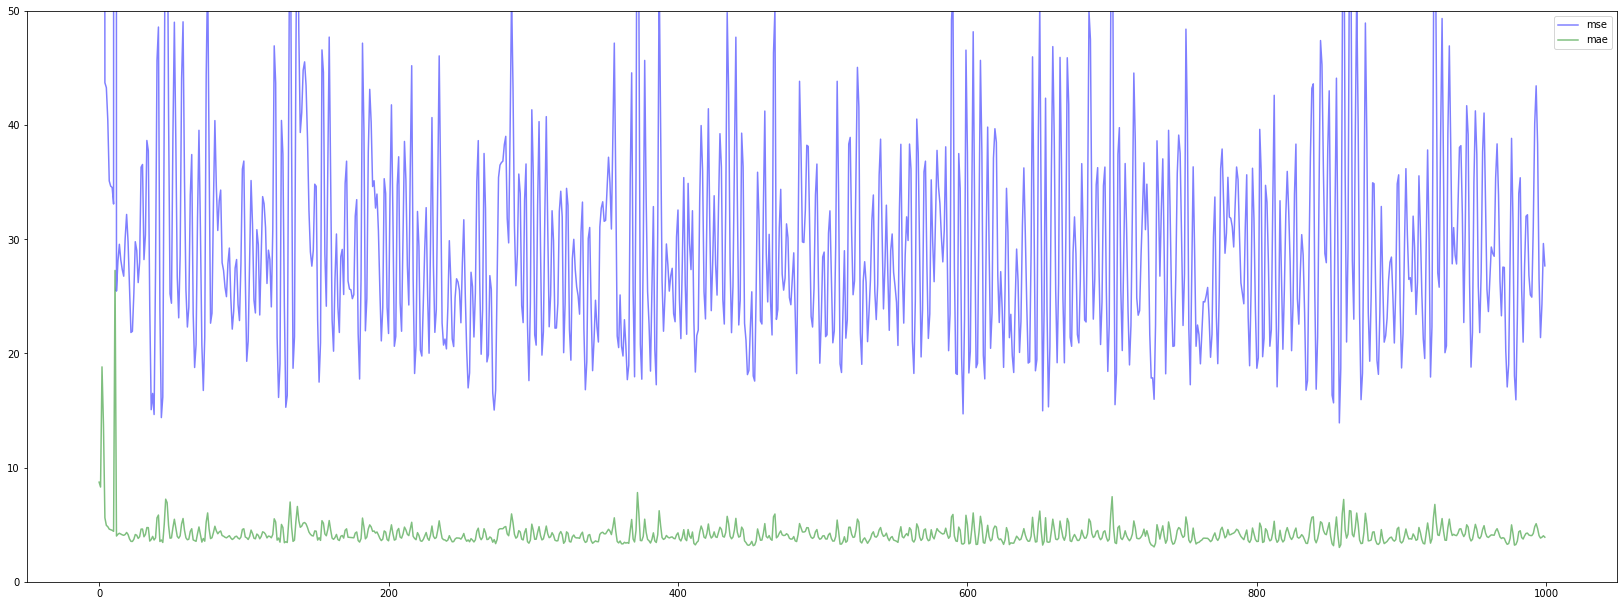

In [946]:
fig = plt.gcf()
fig.set_size_inches(28.5, 10.5)

x = [x[0] for x in test_losses]
y1 = [x[1] for x in test_losses]
y2 = [x[2] for x in test_losses]
plt.plot(x, y1, color='blue', alpha=0.5)
plt.plot(x, y2, color='green', alpha=0.5)
plt.legend(['mse', 'mae'])
plt.ylim(0, 50)

In [893]:
model = GIN(1)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mse = MSELoss()
pipe = Pipeline(model, None)

for epoch in range(100):
    loss_epoch = 0
    for train_batch in train_loader:
        optimizer.zero_grad()
        output = model(train_batch.x, train_batch.edge_index, train_batch.batch)
        predictions, scores = pipe.compute_human_predictions_and_scores(train_batch.human, output, train_batch.y)
        
        loss = mse(predictions, scores)
        loss_epoch += loss.item()
        loss.backward()
        optimizer.step()
    print(epoch, loss_epoch)
#     mse_test, mae_test = pipe.testx(test_loader)
#     print(epoch, loss_epoch, mse_test, mae_test)

0 393.4247817993164
1 57.604268074035645
2 131.87921524047852
3 66.92761421203613
4 83.21756172180176
5 49.26253128051758
6 32.5441312789917
7 75.82892990112305
8 37.1124963760376
9 27.60150718688965
10 44.31222343444824
11 30.597237586975098
12 47.42265796661377
13 72.92849349975586
14 27.448018074035645
15 72.66933059692383
16 66.51628494262695
17 31.90349006652832
18 23.58889675140381
19 40.543774127960205
20 46.7364239692688
21 35.56367588043213
22 25.392948150634766
23 85.71050834655762
24 49.9776554107666
25 15.742505431175232
26 30.94931697845459
27 69.0204906463623
28 28.009620904922485
29 39.747262954711914
30 33.12388849258423
31 44.607184410095215
32 62.77770233154297
33 41.881937980651855
34 34.08803939819336
35 18.9276704788208
36 29.898221015930176
37 21.60626220703125
38 36.95647144317627
39 28.3375301361084
40 17.814868927001953
41 28.514653205871582
42 47.46389389038086
43 51.78189659118652
44 49.95960235595703
45 46.5814094543457
46 18.61174726486206
47 24.94923114776

In [910]:
dataset.human2data.keys()

dict_keys([1112, 1113, 1114, 1117, 1119, 1120, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1154, 1155, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1167, 1168, 1169, 1170, 1171, 1172, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1185, 1188, 118, 119, 120, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 121, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1228, 122, 1231, 1232, 1234, 1235, 1236, 1239, 123, 1240, 1241, 1242, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1258, 1259, 1260, 1261, 1262, 1263, 1266, 1269, 126, 1270, 1272, 1273, 1274, 1279, 127, 1280, 1281, 1282, 1283, 1284, 1287, 1288, 128, 1291, 1292, 1293, 1294, 1295, 1296, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 144, 145, 146, 147, 220, 222, 223, 227, 228, 229, 230, 231, 233, 234, 1115, 1116])

In [909]:
dataset = Dataset('ZG_wpli', 'df_raven.csv', dataset.human2data)

In [911]:
train_loader = dataset.create_loader([1112,1117,1119,1120], batch_size=128, shuffle=True)
test_loader = dataset.create_loader([229, 230, 231, 233, 234, 1115, 1116], batch_size=-1, shuffle=False)

/home/s.ivanov/miniconda3/envs/deepr/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [914]:
for q in test_loader:
    print(q)

Batch(batch=[14400], edge_attr=[453700], edge_index=[2, 453700], human=[225], x=[14400], y=[225])


In [ ]:
# TODO
# 1. Predictions are now aggregated by human. We need to aggregate target labels by human too and compute the loss accordingly. 
# 2. Implement Edge Convolutional layer. 

epoch train mse mae
0 425.89 46.44 6.46
1 432.04 95.56 9.61
2 401.75 117.70 10.73
3 396.62 131.81 11.38
4 397.61 138.13 11.67
5 378.68 141.68 11.82
6 422.34 144.09 11.93
7 463.59 145.80 12.01
8 405.87 147.31 12.07
9 455.20 147.28 12.07
10 398.36 147.68 12.09
11 411.03 147.90 12.10
12 416.43 148.01 12.11
13 453.94 148.09 12.11
14 414.95 148.00 12.11
15 396.22 147.60 12.09
16 386.65 147.82 12.10
17 360.24 147.78 12.10
18 421.85 147.53 12.09
19 417.67 148.55 12.13
20 481.11 148.32 12.12
21 413.12 148.17 12.11
22 403.47 148.44 12.12
23 429.86 148.12 12.11
24 399.23 147.47 12.08
25 461.65 145.91 12.02
26 443.62 145.46 12.00
27 416.16 145.80 12.01
28 400.41 145.44 12.00
29 464.50 145.09 11.98
30 446.69 144.80 11.97
31 499.99 145.41 11.99
32 378.86 145.00 11.98
33 394.06 143.97 11.93
34 399.28 143.92 11.93
35 373.35 143.82 11.92
36 400.49 143.68 11.92
37 467.69 143.15 11.89
38 387.94 142.66 11.87
39 413.42 142.55 11.87
40 414.74 141.59 11.83
41 438.66 141.24 11.81
42 395.31 141.65 11.83
43 43

In [548]:
loss = mse(output.squeeze(), data.y)

In [553]:
data.num_graphs

45

In [538]:
output.squeeze(1).shape

torch.Size([45])

In [532]:
data.y.shape, output.shape

(torch.Size([45]), torch.Size([45, 1]))

In [541]:
output.squeeze()

tensor([-1.3294e+01, -5.2289e+01,  1.2710e+01, -4.1750e+00, -9.6655e-01,
        -3.3066e-01, -1.1896e+01,  3.0244e+00, -1.1103e+00,  7.9592e+00,
        -1.5321e+00, -6.9742e+00,  2.2799e+00, -1.3876e+00, -3.2608e-02,
        -4.0723e+00,  5.3568e+00, -2.6928e+00, -8.1919e+00, -1.5704e+00,
         9.5854e+00, -3.9580e-01, -1.7579e-02,  9.5814e-01, -5.7601e+00,
        -4.4249e+00, -9.8838e-01, -3.8861e+00,  2.3783e+00, -9.6882e+00,
        -1.0652e+01,  9.1143e+00,  4.3333e+00, -2.0830e+01, -2.0734e+01,
         3.3269e+00,  5.7397e+00, -3.0330e+00, -1.3802e+01, -5.6503e+00,
        -9.4553e+00, -2.4933e-01, -9.4942e+00, -5.9723e+00, -9.2478e+00],
       grad_fn=<SqueezeBackward0>)

In [543]:
mse = MSELoss()

tensor(778.1434, grad_fn=<MseLossBackward>)

In [527]:
output

tensor([[-1.3294e+01],
        [-5.2289e+01],
        [ 1.2710e+01],
        [-4.1750e+00],
        [-9.6655e-01],
        [-3.3066e-01],
        [-1.1896e+01],
        [ 3.0244e+00],
        [-1.1103e+00],
        [ 7.9592e+00],
        [-1.5321e+00],
        [-6.9742e+00],
        [ 2.2799e+00],
        [-1.3876e+00],
        [-3.2608e-02],
        [-4.0723e+00],
        [ 5.3568e+00],
        [-2.6928e+00],
        [-8.1919e+00],
        [-1.5704e+00],
        [ 9.5854e+00],
        [-3.9580e-01],
        [-1.7579e-02],
        [ 9.5814e-01],
        [-5.7601e+00],
        [-4.4249e+00],
        [-9.8838e-01],
        [-3.8861e+00],
        [ 2.3783e+00],
        [-9.6882e+00],
        [-1.0652e+01],
        [ 9.1143e+00],
        [ 4.3333e+00],
        [-2.0830e+01],
        [-2.0734e+01],
        [ 3.3269e+00],
        [ 5.7397e+00],
        [-3.0330e+00],
        [-1.3802e+01],
        [-5.6503e+00],
        [-9.4553e+00],
        [-2.4933e-01],
        [-9.4942e+00],
        [-5

In [483]:
nx.degree(G, weight='weight')

DegreeView({0: 0, 1: 4.549137918482721, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3.3121955368749605, 7: 0, 8: 0, 9: 0.694163790713904, 10: 16.772323902767152, 11: 6.689338746778687, 12: 1.432771307928328, 13: 2.0103303478085808, 14: 3.2575591191632833, 15: 5.945579152833943, 16: 3.2251267512095687, 17: 0.665063142506024, 18: 0.6287038583215511, 19: 5.434180695067642, 20: 1.9689035631542384, 21: 1.3551912560904054, 22: 11.540208241570976, 23: 7.900842464533765, 24: 4.72037002910179, 25: 2.0044793874417235, 26: 8.438604069712481, 27: 7.3995453093032815, 28: 3.8767659492034325, 29: 0, 30: 3.9241740112875143, 31: 7.939586980014253, 32: 0, 33: 0, 34: 3.3035324593029953, 35: 1.9968787359183837, 36: 8.559664541295831, 37: 0, 38: 5.836712123989325, 39: 0.6730185429527562, 40: 6.051296285122883, 41: 2.663268724262803, 42: 2.6611113611185133, 43: 6.039404974466794, 44: 5.401150206467807, 45: 3.2189657901253774, 46: 0, 47: 1.3464253669072286, 48: 1.3100660827227557, 49: 13.62567640175727, 50: 0, 51: 6.73332225

In [522]:
dataset = nn.create_dataset([1112])

/home/s.ivanov/miniconda3/envs/deepr/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [513]:
for i in dataset:
    print(i)

Batch(batch=[2880], edge_attr=[90740], edge_index=[2, 90740], x=[2880], y=[45])


In [393]:
data = Dataset('ZG_wpli', 'df_raven.csv', data.human2data)

In [418]:
a = TUDataset('tmp', 'MUTAG')

Extracting tmp/MUTAG/MUTAG.zip
Processing...
Done!


In [486]:
a[0].x

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

In [430]:
d=  from_networkx(G)
d.y = 1
d

Data(edge_index=[2, 404], weight=[404], y=[1])

In [434]:
d.weight.size()

torch.Size([404])

In [445]:
a[0]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

In [450]:
data.human2data[1112]

[(<networkx.classes.graph.Graph at 0x7f5281f6a588>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281f6a7f0>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281f6af98>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281f6ae80>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281f6a6d8>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11c88>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11cc0>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11cf8>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11d30>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11d68>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11da0>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11dd8>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11e10>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11e48>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11e80>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11eb8>, 22.0),
 (<networkx.classes.graph.Graph at 0x7f5281e11ef0>, 22.0

In [444]:
from_networkx(G, 1, 'edge_attr')

Data(edge_attr=[404], edge_index=[2, 404], y=[1])

In [387]:
len(data.human2data)

151

In [391]:
data.predict()

TypeError: predict() missing 1 required positional argument: 'self'

In [353]:
data.get_graph_data()

1112 22.0
1113 15.0
1114 17.0
1117 13.0
1119 19.0
1120 18.0
1127 12.0
1128 15.0
1129 7.0
1130 6.0
1131 14.0
1132 12.0
1133 17.0
1134 15.0
1135 14.0
1136 16.0
1137 15.0
1139 23.0
1140 18.0
1141 11.0
1142 16.0
1143 11.0
1144 16.0
1145 8.0
1146 17.0
1147 17.0
1148 21.0
1149 12.0
1151 6.0
1152 12.0
1153 20.0
1154 17.0
1155 15.0
1157 14.0
1158 12.0
1159 15.0
1160 18.0
1161 14.0
1162 13.0
1163 16.0
1165 2.0
1167 10.0
1168 15.0
1169 16.0
1170 21.0
1171 18.0
1172 15.0
1174 11.0
1175 24.0
1176 20.0
1177 20.0
1178 22.0
1179 9.0
1180 15.0
1181 18.0
1182 20.0
1183 20.0
1184 nan
1185 15.0
1188 9.0
118 15.0
119 13.0
120 19.0
1213 21.0
1214 22.0
1215 24.0
1216 21.0
1217 16.0
1218 12.0
1219 10.0
121 16.0
1220 16.0
1221 13.0
1222 12.0
1223 12.0
1224 8.0
1225 21.0
1226 16.0
1228 15.0
122 22.0
1231 10.0
1232 12.0
1234 18.0
1235 12.0
1236 14.0
1239 22.0
123 9.0
1240 21.0
1241 24.0
1242 19.0
1245 13.0
1246 20.0
1247 18.0
1248 26.0
1249 19.0
1250 15.0
1251 22.0
1252 25.0
1253 7.0
1258 15.0
1259 25.0
1260 24

defaultdict(list,
            {1112: [(<networkx.classes.graph.Graph at 0x7f53ec9f6c50>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53eca4ea58>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53eccb4e80>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53eccb4f60>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6ac8>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6d30>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6748>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6a20>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6b38>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6cc0>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f6eb8>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9f69b0>, 22.0),
              (<networkx.classes.graph.Graph at 0x7f53ec9d85f8>, 22.0),
              (<networkx.classes.graph.G

In [339]:
humans, human2files = data.get_humans()

In [341]:
next(kfold.split(humans))

(array([  0,   1,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  46,  47,  48,  49,  50,  51,  52,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  69,  70,  72,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,  87,
         88,  89,  90,  91,  94,  95,  96,  97,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158,
        159, 160, 161, 162]),
 array([  2,   8,  18,  23,  45,  53,  68,  71,  73,  84,  92,  93,  98,
        108, 127, 154, 163]))

In [310]:
from sklearn.model_selection import KFold

In [312]:
kfold = KFold(10, shuffle=True)
for train_ix, test_ix in kfold.split(matrix_and_label):
    print(train_ix)
    print(test_ix)
    print()

[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  58
  59  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  98 100 101 102 103 105 106 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 135 136 137 138 139
 140 142 143 144 145 146 147 148 149 150 151 152 153 155 156 157]
[ 12  17  33  35  57  60  66  97  99 104 107 108 109 134 141 154]

[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  42  43  44  46  47  48  49  50  51  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  72  73  74  75  76  77  78
  79  80  81  83  84  85  86  87  88  91  92  93  94  95  97  98

In [308]:
matrix_and_label = data.get_matrix_and_label()

In [309]:
data.num_graphs

158

In [294]:
human2iq

KeyError: 1164

In [251]:
graphs = data.get_graphs_threshold(percentiles=[50])

In [256]:
data.get_graphs_path()

['ZG_wpli/1112_ZG_6-sec_wpli_sensors_13-20.csv',
 'ZG_wpli/1112_ZG_6-sec_wpli_sensors_20-30.csv',
 'ZG_wpli/1112_ZG_6-sec_wpli_sensors_4-30.csv',
 'ZG_wpli/1112_ZG_6-sec_wpli_sensors_4-8.csv',
 'ZG_wpli/1112_ZG_6-sec_wpli_sensors_8-13.csv',
 'ZG_wpli/1113_ZG_6-sec_wpli_sensors_13-20.csv',
 'ZG_wpli/1113_ZG_6-sec_wpli_sensors_20-30.csv',
 'ZG_wpli/1113_ZG_6-sec_wpli_sensors_4-30.csv',
 'ZG_wpli/1113_ZG_6-sec_wpli_sensors_4-8.csv',
 'ZG_wpli/1113_ZG_6-sec_wpli_sensors_8-13.csv',
 'ZG_wpli/1114_ZG_6-sec_wpli_sensors_13-20.csv',
 'ZG_wpli/1114_ZG_6-sec_wpli_sensors_20-30.csv',
 'ZG_wpli/1114_ZG_6-sec_wpli_sensors_4-30.csv',
 'ZG_wpli/1114_ZG_6-sec_wpli_sensors_4-8.csv',
 'ZG_wpli/1114_ZG_6-sec_wpli_sensors_8-13.csv',
 'ZG_wpli/1117_ZG_6-sec_wpli_sensors_13-20.csv',
 'ZG_wpli/1117_ZG_6-sec_wpli_sensors_20-30.csv',
 'ZG_wpli/1117_ZG_6-sec_wpli_sensors_4-30.csv',
 'ZG_wpli/1117_ZG_6-sec_wpli_sensors_4-8.csv',
 'ZG_wpli/1117_ZG_6-sec_wpli_sensors_8-13.csv',
 'ZG_wpli/1119_ZG_6-sec_wpli_sensors

In [252]:
len(graphs)

820

In [44]:
os.listdir('ZG_wpli/')

['1112_ZG_6-sec_wpli_sensors_13-20.csv',
 '1112_ZG_6-sec_wpli_sensors_20-30.csv',
 '1112_ZG_6-sec_wpli_sensors_4-30.csv',
 '1112_ZG_6-sec_wpli_sensors_4-8.csv',
 '1112_ZG_6-sec_wpli_sensors_8-13.csv',
 '1113_ZG_6-sec_wpli_sensors_13-20.csv',
 '1113_ZG_6-sec_wpli_sensors_20-30.csv',
 '1113_ZG_6-sec_wpli_sensors_4-30.csv',
 '1113_ZG_6-sec_wpli_sensors_4-8.csv',
 '1113_ZG_6-sec_wpli_sensors_8-13.csv',
 '1114_ZG_6-sec_wpli_sensors_13-20.csv',
 '1114_ZG_6-sec_wpli_sensors_20-30.csv',
 '1114_ZG_6-sec_wpli_sensors_4-30.csv',
 '1114_ZG_6-sec_wpli_sensors_4-8.csv',
 '1114_ZG_6-sec_wpli_sensors_8-13.csv',
 '1117_ZG_6-sec_wpli_sensors_13-20.csv',
 '1117_ZG_6-sec_wpli_sensors_20-30.csv',
 '1117_ZG_6-sec_wpli_sensors_4-30.csv',
 '1117_ZG_6-sec_wpli_sensors_4-8.csv',
 '1117_ZG_6-sec_wpli_sensors_8-13.csv',
 '1119_ZG_6-sec_wpli_sensors_13-20.csv',
 '1119_ZG_6-sec_wpli_sensors_20-30.csv',
 '1119_ZG_6-sec_wpli_sensors_4-30.csv',
 '1119_ZG_6-sec_wpli_sensors_4-8.csv',
 '1119_ZG_6-sec_wpli_sensors_8-13.c

In [37]:
fns = os.listdir('eec')
i = 1
j = 1
for fn in fns:
    if fn.endswith('npz'):
        j += 1
        A = np.load(f'eec/{fn}')
        files = A.__dict__['files']
        for f in files:
            print(i, j, fn, f, intelligence.get(int(f.split('_')[0]), None), A[f].shape)
            i += 1

1 2 1111.npz 1111_4-8 21.0 (64, 64, 105)
2 2 1111.npz 1111_8-13 21.0 (64, 64, 105)
3 2 1111.npz 1111_13-20 21.0 (64, 64, 105)
4 2 1111.npz 1111_20-30 21.0 (64, 64, 105)
5 2 1111.npz 1111_4-30 21.0 (64, 64, 105)
6 3 1112.npz 1112_4-8 22.0 (64, 64, 82)
7 3 1112.npz 1112_8-13 22.0 (64, 64, 82)
8 3 1112.npz 1112_13-20 22.0 (64, 64, 82)
9 3 1112.npz 1112_20-30 22.0 (64, 64, 82)
10 3 1112.npz 1112_4-30 22.0 (64, 64, 82)
11 4 1113.npz 1113_4-8 15.0 (64, 64, 107)
12 4 1113.npz 1113_8-13 15.0 (64, 64, 107)
13 4 1113.npz 1113_13-20 15.0 (64, 64, 107)
14 4 1113.npz 1113_20-30 15.0 (64, 64, 107)
15 4 1113.npz 1113_4-30 15.0 (64, 64, 107)
16 5 1114.npz 1114_4-8 17.0 (65, 65, 108)
17 5 1114.npz 1114_8-13 17.0 (65, 65, 108)
18 5 1114.npz 1114_13-20 17.0 (65, 65, 108)
19 5 1114.npz 1114_20-30 17.0 (65, 65, 108)
20 5 1114.npz 1114_4-30 17.0 (65, 65, 108)
21 6 1117.npz 1117_4-8 13.0 (64, 64, 102)
22 6 1117.npz 1117_8-13 13.0 (64, 64, 102)
23 6 1117.npz 1117_13-20 13.0 (64, 64, 102)
24 6 1117.npz 1117_20

203 42 1168.npz 1168_13-20 15.0 (64, 64, 89)
204 42 1168.npz 1168_20-30 15.0 (64, 64, 89)
205 42 1168.npz 1168_4-30 15.0 (64, 64, 89)
206 43 1169.npz 1169_4-8 16.0 (64, 64, 92)
207 43 1169.npz 1169_8-13 16.0 (64, 64, 92)
208 43 1169.npz 1169_13-20 16.0 (64, 64, 92)
209 43 1169.npz 1169_20-30 16.0 (64, 64, 92)
210 43 1169.npz 1169_4-30 16.0 (64, 64, 92)
211 44 1170.npz 1170_4-8 21.0 (64, 64, 106)
212 44 1170.npz 1170_8-13 21.0 (64, 64, 106)
213 44 1170.npz 1170_13-20 21.0 (64, 64, 106)
214 44 1170.npz 1170_20-30 21.0 (64, 64, 106)
215 44 1170.npz 1170_4-30 21.0 (64, 64, 106)
216 45 1171.npz 1171_4-8 18.0 (64, 64, 66)
217 45 1171.npz 1171_8-13 18.0 (64, 64, 66)
218 45 1171.npz 1171_13-20 18.0 (64, 64, 66)
219 45 1171.npz 1171_20-30 18.0 (64, 64, 66)
220 45 1171.npz 1171_4-30 18.0 (64, 64, 66)
221 46 1172.npz 1172_4-8 15.0 (64, 64, 89)
222 46 1172.npz 1172_8-13 15.0 (64, 64, 89)
223 46 1172.npz 1172_13-20 15.0 (64, 64, 89)
224 46 1172.npz 1172_20-30 15.0 (64, 64, 89)
225 46 1172.npz 1172_

399 81 128.npz 128_20-30 22.0 (64, 64, 99)
400 81 128.npz 128_4-30 22.0 (64, 64, 99)
401 82 129.npz 129_4-8 22.0 (64, 64, 99)
402 82 129.npz 129_8-13 22.0 (64, 64, 99)
403 82 129.npz 129_13-20 22.0 (64, 64, 99)
404 82 129.npz 129_20-30 22.0 (64, 64, 99)
405 82 129.npz 129_4-30 22.0 (64, 64, 99)
406 83 130.npz 130_4-8 17.0 (64, 64, 91)
407 83 130.npz 130_8-13 17.0 (64, 64, 91)
408 83 130.npz 130_13-20 17.0 (64, 64, 91)
409 83 130.npz 130_20-30 17.0 (64, 64, 91)
410 83 130.npz 130_4-30 17.0 (64, 64, 91)
411 84 131.npz 131_4-8 18.0 (64, 64, 75)
412 84 131.npz 131_8-13 18.0 (64, 64, 75)
413 84 131.npz 131_13-20 18.0 (64, 64, 75)
414 84 131.npz 131_20-30 18.0 (64, 64, 75)
415 84 131.npz 131_4-30 18.0 (64, 64, 75)
416 85 132.npz 132_4-8 14.0 (64, 64, 85)
417 85 132.npz 132_8-13 14.0 (64, 64, 85)
418 85 132.npz 132_13-20 14.0 (64, 64, 85)
419 85 132.npz 132_20-30 14.0 (64, 64, 85)
420 85 132.npz 132_4-30 14.0 (64, 64, 85)
421 86 133.npz 133_4-8 19.0 (64, 64, 81)
422 86 133.npz 133_8-13 19.0 (

In [10]:
ritm1 = np.nan_to_num(A[A.files[0]], 0)
ritm1_first20_mean = np.mean(ritm1[:, :, :21], axis=-1)

In [42]:
ritms = []
As = []
A = np.load(f'eec/1111.npz')
for f in A.files:
    print(f)
    ritm = A[f]
    np.nan_to_num(ritm, 0)
    As.append(ritm)
    ritms.append(np.mean(ritm, axis=-1))

1111_4-8
1111_8-13
1111_13-20
1111_20-30
1111_4-30


In [43]:
np.all(As[0] == As[1])

True

In [38]:
As[0]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.24332891, 0.2900308 , 0.13348938, ..., 0.03980656,
         0.19356283, 0.5988823 ],
        [0.1392653 , 0.05735841, 0.45436837, ..., 0.24745841,
         0.05391997, 0.4335145 ],
        ...,
        [0.35066342, 0.08056496, 0.66515636, ..., 0.24244185,
         0.04494729, 0.2925658 ],
        [0.30067158, 0.43520087, 0.31214483, ..., 0.22328859,
         0.16443152, 0.00490742],
        [0.01737726, 0.07746566, 0.5160614 , ..., 0.12691602,
         0.0714346 , 0.42394295]],

       [[0.24332891, 0.2900308 , 0.13348938, ..., 0.03980656,
         0.19356283, 0.5988823 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.19640487, 0.49960442, 0.32214274, ..., 0.27809104,
         0.10008375, 0.41741403],
        ...,
        [0.04012055, 0.80290495, 0.68552042, ..., 0.55148309,
         0.09404091, 0.32288588],
        [0.0

In [19]:
ritm1_first20_mean[0]

array([0.        , 0.3241738 , 0.27806554, 0.28854719, 0.28938306,
       0.26735952, 0.2744812 , 0.16314366, 0.22132557, 0.23776181,
       0.30446078, 0.20729324, 0.23038611, 0.29033333, 0.28502927,
       0.33467482, 0.25968031, 0.30355711, 0.24234826, 0.19609058,
       0.29636034, 0.30532894, 0.25111005, 0.28817244, 0.26966638,
       0.30756548, 0.26957343, 0.26151633, 0.25117255, 0.27287495,
       0.31203572, 0.27617063, 0.30582743, 0.27893348, 0.19742997,
       0.32983139, 0.18822256, 0.21394833, 0.2644002 , 0.19797568,
       0.29467743, 0.28173172, 0.26009015, 0.27519009, 0.28930966,
       0.29263442, 0.25395511, 0.22984816, 0.31096358, 0.33089866,
       0.30120285, 0.22076651, 0.23952812, 0.30514384, 0.24227308,
       0.18467407, 0.25409972, 0.3328974 , 0.28423422, 0.26668195,
       0.31428672, 0.29351663, 0.31770808, 0.30334728])